In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from scipy.spatial.distance import cdist 
import math
import warnings
import random

## Problem 1 (25 points)
Create and print out a scatter plot of this dataset, eruption time versus waiting time. (10 points)
How many clusters do you see based on your scatter plot? For the purposes of this question, a cluster is a “blob” of many data points that are close together, with regions of fewer data points between it and other “blobs”/clusters. (5 points)



The answers of a and b are below:

In [2]:
df = pd.read_csv("faithful.csv")
df

,eruptions,waiting
0,3.600,79
1,1.800,54
2,3.333,74
3,2.283,62
4,4.533,85
...,...,...
267,4.117,81
268,2.150,46
269,4.417,90
270,1.817,46


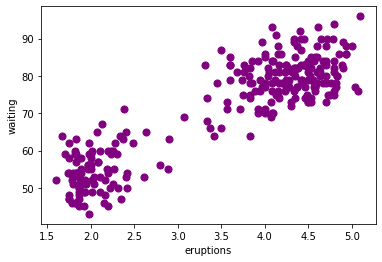

In [3]:
df.plot.scatter(x = 'eruptions', y = 'waiting',s=50, c='purple');

Baed on the scatter plot above, I see two clusters. One of them is located top-right of the plot, the other one is located bottom-left of the plot. 

(c) Describe the steps of a hierarchical clustering algorithm. Based on your scatter plot, would this method be appropriate for this dataset?
Hierarchical clustering makes each instance in the dataset into a trivial mini cluster. Then, it merges the two closest cluster as new clusters. It reapets the aforementioned steps, until all of the instances are in a single cluster, or until the termination conidtion occures. These staps are for hierarchical aggmolerative clustering. hierarchical divisive analysis (DIANA) works inversely. So, first all of the instances are in a single cluster. Then, it does inverse form of AGNES. Eventually, each nodes form a cluster, or the termination condition occures.  I think hierarchical clustering can be good also for our dataset, however, it needs a termination condition. For example, if the dissimilarity is more than something (the dsitance between the two cluster) then stop the algorithm and do not merge any clusters anymore. 

## Problem 2 (75 points)
Implement the k-means algorithm in Python, and use it to perform clustering on the Old Faithful dataset. Use the number of clusters that you identified in Problem 1. Be sure to ignore the first column, which contains instance ID numbers. In your notebook, including the following items:
Your source code for the k-means algorithm. You need to implement the algorithm from scratch. (45 points)
A scatter plot of your final clustering, with the data points in each cluster color-coded, or plotted with different symbols. Include the cluster centers in your plot. (10 points)
 A plot of the k-means objective function versus iterations of the algorithm. Recall that the objective function is  (10 points)


In [4]:
#kmeans from scratch
def kmeans_sara(df, k, data_num):
    x_list, y_list = generate_random_points(df, k) # chooses different random points from dataset for initial clusters

    df2 = df.copy() # we copied the dataframe
    check = True
    objective_function = [] # stores all of the objectective function values from each iteration
    iter = 0 # iteration
    colors = {} # colors for the clusters
    while (check):
        i = 0
        # calculates distance forom each point to its cluster centroid
        df2, total_points, obj_func = calculate_distance(df2, x_list, y_list, k)

        # sum of objective function values
        total_obf = 0
        for obj in obj_func.values():
            total_obf += obj

        # adds current objective function value to the list
        objective_function.append(total_obf)

        # stops the while loop when objective function starts to converge
        if abs(objective_function[iter - 1] - objective_function[iter]) < 0.01 and iter >= 1:
            check = False

        # calculates new centroids
        for coordinates in total_points.values():
            new_x, new_y = calculate_mean(coordinates)
            x_list[i] = new_x
            y_list[i] = new_y
            i += 1

        # plots the initial cluster centers
        if iter == 0:
            colors = initial_cluster_centers_plot(df2, x_list, y_list, k, data_num)

        iter += 1

    plot_objective_function(objective_function) # plots the objective function
    final_cluster_centers_plot(df2, x_list, y_list, colors, iter, objective_function[-1]) # plots final


In [5]:
# define a function to calculates euclid distance for two points
def euclid_calculator(x1, y1, x2, y2):
    distance = np.sqrt(np.square(abs(x1 - x2)) + np.square(abs(y1 - y2))) # euclid distance formula
    return distance

In [6]:
def calculate_distance(df_distance, x_list, y_list, k):
    obj_func = {} # stores object functions for each distances
    total_points = {} # stores all data points for each cluster centroids
    # creates points with names according to number of k
    for x in range(1, k + 1):
        name = 'point_'
        obj_func[name + str(x)] = 0
        total_points[name + str(x)] = []

    for index, row in df_distance.iterrows():
        points_distance = {}
        for x in range(1, k+1):
            name = 'point_'
            points_distance[name + str(x)] = 0
        for x, y, point in zip(x_list, y_list, points_distance.keys()):
            distance = euclid_calculator(x, y, row['x'], row['y']) # calculates distance for determine point is close to which center
            df_distance.loc[index, point] = distance # stores points with distances
            points_distance[point] = distance

        # sorts for finding every point close to which center
        sorted_dist = sorted(points_distance.items(), key=lambda kv: kv[1])
        point = [row['x'], row['y']]
        point_type = sorted_dist[0][0]
        obj_func[point_type] += np.square(sorted_dist[0][1])
        df_distance.loc[index, 'point_type'] = point_type
        total_points[point_type].append(tuple(point))

    return df_distance, total_points, obj_func

In [7]:
# calculates min x and y values for finding the new centroids
def calculate_mean(distance_list):
    x_total = 0
    y_total = 0
    for item in distance_list:
        x_total += item[0]
        y_total += item[1]

    mean_x = x_total / len(distance_list)
    mean_y = y_total / len(distance_list)

    return mean_x, mean_y

In [8]:
# calculates sum of all distances
def total_dist(dist):
    dist_sum = 0
    for item in dist:
        dist_sum += item
    return dist_sum


In [9]:
# plots objoctive function
def plot_objective_function(obj_func):
    x_axis = list(range(1, len(obj_func) + 1))
    # plotting the points
    plt.plot(x_axis, obj_func, marker='o')
    # naming the x axis
    plt.xlabel('Iteration')
    # naming the y axis
    plt.ylabel('Objective Function Value')
    # giving a title to my graph
    plt.title('Objective Function')
    # function to show the plot
    plt.show()

In [10]:
# reading csv file according to path and adds column names for separating class, x and y values
def reading_data(path):
    data = pd.read_csv("faithful.csv")  # reading csv file
    first_row = []
    # appending first row in a list
    for i in range(0, 3):
        first_row.append(float(data.columns[i]))

    data.loc[-1] = first_row  # adding a row
    data.index = data.index + 1  # shifting index
    data = data.sort_index()  # sorting indexes

    data.columns = ["x", "y", "class"]  # assigning column names
    return data

In [11]:
# visualizing scatter plot version of data
def scatter_plot(plotted_df):
    fig, ax = plt.subplots()
    # selecting x and y axises without labels
    ax.scatter(plotted_df['x'], plotted_df['y'], c='purple', s=20)
    plt.xlabel('eruptions time')  # entering name for x axis
    plt.ylabel('waiting time')  # entering name for y axis
    plt.title("Dataset")  # entering a title for plot
    plt.show()

In [12]:
# plots the initial cluster centers
def initial_cluster_centers_plot(initial_df, x_list, y_list, k, data_num):
    fig, ax = plt.subplots()
    # defining colors for each clustered points at the beginning according to k number
    colors = {'point_1': 'lime',
                     'point_2': 'orange',
                     }


    # selecting x and y axises with point type of each row
    ax.scatter(initial_df['x'], initial_df['y'], c=initial_df['point_type'].map(colors), s=20)
    # draws the new centroids according to mean values
    for x, y in zip(x_list, y_list):
        plt.scatter(x, y, c='black', s=20)

    plt.xlabel('eruptions \n Initial Cluster Centers \n Dataset='+str(data_num)+'\n k='+str(k))
    plt.ylabel('waiting')
    plt.title("k-Means")
    plt.show()

    return colors

In [13]:
# plots the final cluster centers
def final_cluster_centers_plot(final_df, x_list, y_list, colors, iter_num, final_obf):
    fig, ax = plt.subplots()

    ax.scatter(final_df['x'], final_df['y'], c=final_df['point_type'].map(colors), s=20)

    for x, y in zip(x_list, y_list):
        plt.scatter(x, y, c='black', s=20)

    plt.xlabel('eruptions \n Final Cluster Centers\n Iteration Count=' +str(iter_num)+ '\n Objective Function Value:' +str(final_obf))
    plt.ylabel('waiting')
    plt.title("k-Means")
    plt.show()

In [14]:
# generates random points for initial cluster centroids
def generate_random_points(dataset, k):
    rand_x, rand_y = [], []
    random_points = random.sample(range(1, len(dataset) - 1), k)
    for rand_index in random_points:
        rand_x.append(dataset.iloc[rand_index][0])
        rand_y.append(dataset.iloc[rand_index][1])
    return rand_x, rand_y

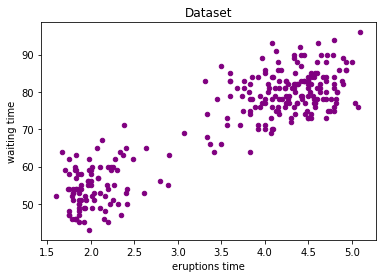

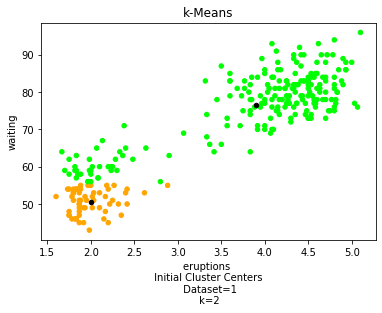

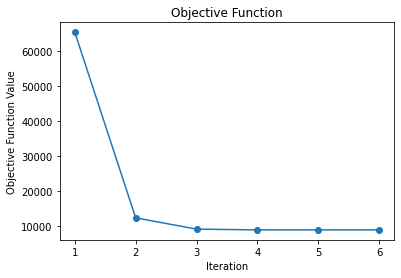

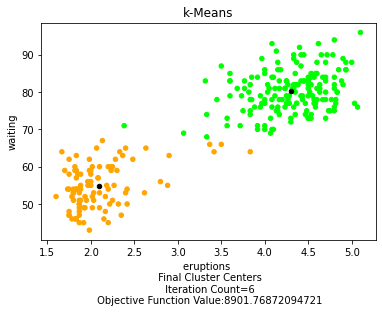

In [15]:
if __name__ == "__main__":

    for i in range(1, 2):
        dataset = pd.read_csv("faithful.csv")
        dataset [['x', 'y']] =  dataset [['eruptions', 'waiting']]
        unlabelled_data = dataset[['x', 'y']]

        scatter_plot(unlabelled_data)

        if i == 1:
            kmeans_sara(unlabelled_data, 2, i)

(d):
Did the method manage to find the clusters that you identified in Problem 1? If not, did it help to run the method again with another random initialization? (10 points)
For the first iteration, as you can see in the initial plot above, the performance of the model is not good. It is not efficient in finding the two clusters that we recignozed before. However, when I repated the model with another randomized centroids, from the second iteration, the objective function value has decreased a lot, and also the two clusters are determined by the model. That means after second iteration of the model, its performance has imporved a lot!
for not being in local optimal we repeat the model for deifferent iterations.
Getting stuck in local optimal is due to random initialization of centroids and chance. It may be the case that the centroids have been initialized in such a way that  resulting in poor clustering .
If we had run the algorithm only once, we could have been unlucky due to the random initialization of the centroids, getting a result that is not optimal or is just local optimal.

